# Метод стрельбы

Рассмотрим нелинейную краевую задачу:

$ \begin{equation}
\left\{
\begin{split}
y'' = F(x,y,y')| x \in [x_L,x_R] \\
l_1(y,y') = 0 | x = x_L \\ 
l_2(y,y') = 0 | x = x_R \\ 
\end{split}\right.
\end{equation} $

Основная идея решения - свести нашу задачу к задаче Коши. Для этого необходимо определить значения $y_L = y(x_L), y_L' = y'(x_L)$ или $y_R = y(x_R), y_R'  = y'(x_R) $ . Не зная $y, y'$ , из имеющейся информации сделать это аналитически может быть затруднительно, поэтому введем на левом конце дополнительное граничное условие, зависящее от параметра $\theta$:

$ \begin{equation}
\left\{
\begin{split}
y'' = F(x,y,y')| x \in [x_L,x_R] \\
l_1(y,y') = 0 | x = x_L \\ 
l_c(y,y',\theta) = 0 | x = x_L \\ 
\end{split}\right.
\end{equation} $

Выбор подходящей $l_c$ может варьироваться. В простейшем случае, $l_c(y,y',\theta) = y-\theta$ или $l_c(y,y',\theta) = y'-\theta$ , то есть $l_c = 0|x=x_L$ тождественно $y_L = \theta$ или $y_L' = \theta$ . В любом случае, задав $l_c$ и принимая во внимание $l_1$ мы должны получить простую возможность вычисления значений $y_L(\theta)$ и $y_L'(\theta)$, после чего задача сведется к задаче Коши.

Численно решив задачу Коши при конкретном $\theta$ (например, методом Рунге-Кутты), мы получим зависящий от параметра ответ $y(\theta)$, который, однако, не обязательно будет удолетворять условию на правой границе. Обозначим невязку $T(\theta) = l_2(y(\theta),y'(\theta))$ Мы будем пытаться подобрать $\theta$, при котором $T(\theta)$ становится достаточно близко к нулю. Этот процесс метафорически схож с серией пристрелочных выстрелов по цели, благодаря чему метод и получил свое название.

## Пример

Рассмотрим уравнение $y'' = \frac{(y')^2}{y} - y'\tan x $

Можно убедиться, что его решения выглядят как $ y = \alpha e^{\beta\sin x} $ . Притворимся, что мы этого не знаем, и попробуем решить краевую задачу на отрезке $[0,1]$ с $y(0) = 1$ , $y(\frac{\pi}{2}) = 2$

Нам нужно задать для задачи Коши $y'(0) = \theta$ 

Начнем решение

In [5]:
import numpy as np

Нам удобно рассматривать эволюцию вектора состояния системы $ \vec{s} = (x,y,y') $ как:


$ \vec{s}' = D\vec{s} 
\Leftrightarrow  \begin{pmatrix} x \\ y \\ y' \end{pmatrix}' = \begin{pmatrix} 1 \\ y' \\ F(x,y,y') \end{pmatrix}$

In [45]:
def F(x,y,dy):
    return dy**2/y - dy*np.tan(x)


def D(s):
    x, y, dy = s
    return np.array((1, dy, F(x,y,dy)))


X_start, X_final = 0, np.pi/2

Y_start, Y_final = 1, 2


Зададим численный метод (Рунге-Кутта 4 порядка) и шаг. Известно, что ошибка метода RK4 на отрезке составляет ~ O(h^4). 

Мы можем установить желаемое отклонение от верного ответа eps и вычислить из него число шагов. К примеру, мы хотим иметь 8 цифр точности:

In [60]:
eps = 10**(-8)

StepsNumber = int((1/eps)**(1/4)) #

DeltaX = (X_final-X_start)/StepsNumber

StepsNumber, DeltaX


(100, 0.015707963267948967)

Наша оценка дает, что установив 100 шагов, мы получим желаемое.

In [61]:

def RK4_step(s):
    d1 = DeltaX*D(s)
    d2 = DeltaX*D(s+d1/2)
    d3 = DeltaX*D(s+d2/2)
    d4 = DeltaX*D(s+d3)

    return s + ( d1 + 2*d2 + 2*d3 + d4 )/6

Определим функцию невязки T, вычисляющую отклонение от нашей цели

In [62]:
def T(theta):

    dY_start = theta

    state = np.array((X_start, Y_start, dY_start))
 
    for _ in range(StepsNumber):
        state = RK4_step(state)

    Y_final_calc = state[1]

    return Y_final_calc - Y_final

Будем пытаться попасть в цель | подобрать $\theta$  методом секущих с выбором точки (regula falsi):

Дадим два наметочных выстрела произвольным образом (к примеру, возьмем $\theta_1,\theta_2 = 0,1$). Вычислим $d_1, d_2 = T(\theta_1), T(\theta_2)$

Нарисуем на плоскости $ (\theta, d) $ две полученные точки и проведем прямую через них. Возьмем за $\theta_3$ $\theta$-координату точки пересечения этой прямой с абциссой. Построим $d_3 = T(\theta_3)$ . Если точность невязки $d_3$ не устроила нас, повторим процедуру с новой парой точек: $\theta_3$ и одной из точек $(\theta_1, \theta_2)$, выбранной так: 

* Если $d_1$ и $d_2$ одного знака, выбрать $\theta$, который ближе к $\theta_3$ . 

* Если $d_1$ и $d_2$ разных знаков, выбрать $\theta$, невязка которого имеет знак, противоположный $d_3$

* Если $d_1 = d_2$, $\theta_3$ вычислить невозможно. Кроме того, если $d_1*d_2 >> \epsilon^2$ , но $|d_1 - d_2| < \epsilon $ , т.е. невязки очень близки и при этом далеки от нуля, на следующем шаге мы можем уйти далеко в зону нефизичности задачи. В этом случае наш поиск корня окончился неудачей и мы перезапускаем алгоритм с другими двумя начальными точками.

Метод гарантировано сойдется, если мы сразу или за несколько итераций смогли подобрать $d_1$ и $d_2$ разных знаков - в этом случае дальше мы будем быстро сужать интервал поиска. Так же метод гарантировано сойдется, если нам удалось угадать правильное направление до корня и функция $T''$ на интервале от корня до близжайшей к нему вычисленной нами точке имеет постоянный знак.




In [63]:
Theta_left, Theta_right = 0, 1
Discr_left, Discr_right  = T(Theta_left), T(Theta_right)

ThetaList = [Theta_left, Theta_right]

while True:

    if abs(Discr_left) < eps:
        Theta = Theta_left
        break

    if abs(Discr_right) < eps:
        Theta = Theta_right
        break

    if abs(Discr_right - Discr_left) < eps:
        raise ValueError('Неудачный выбор начальных точек! Метод не сошелся.')

    Theta = (Discr_right*Theta_left - Discr_left*Theta_right)/(Discr_right-Discr_left)
    ThetaList.append(Theta)

    Discr = T(Theta)

    if Discr_right*Discr_left > 0:
        if abs(Theta-Theta_left) > abs(Theta-Theta_right):
            Theta_left, Discr_left = Theta, Discr
        else:
            Theta_right, Discr_right = Theta, Discr
    else:
        if Discr*Discr_left > 0:
            Theta_left, Discr_left = Theta, Discr
        else:
            Theta_right, Discr_right = Theta, Discr

    print(Theta, Discr)


0.5819767000608468 -0.21042761058028514
0.6766926990282881 -0.03263968517749083
0.6907456300539359 -0.004797330967438507
0.6927974047526977 -0.000699422017549578
0.6930962501715657 -0.0001018509068881901
0.6931397623298602 -1.4829127973792211e-05
0.6931460974137827 -2.159013817948363e-06
0.6931470197534266 -3.143356530621588e-07
0.6931471540388606 -4.5764807499182325e-08
0.6931471735897661 -6.662996598905124e-09


Метод сходится за 9 шагов. Сравним наше полученное решение с аналитическим.
Истинное $\theta = ln(2) = 0.693147181$ . Можно видеть, что то, что посчиталось у нас, отличается в 8 знаке от истинного значения параметра. Подставив истинное значение, мы получим:

In [69]:
Theta_analitical = np.log(2)

T(Theta_analitical), np.log(2)

(7.277361380175762e-09, 0.6931471805599453)

Нет особого смысла выставлять точность выше, чем установленная точность Рунге-Кутты для задачи Коши: в противном случае решение отклонится и будет "целиться" в точку численного решения краевой задачи, отличную от её истинного решения.

Напоследок нарисуем графики сходимости. Для этого придется пересчитать всё заново, дабы вычислить траектории (мы сохранили наши решения в ThetaList)

In [65]:
@np.vectorize
def Y_analitical(x):
    return 2**np.sin(x)

In [66]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

Так как графики очень быстро сходятся, имеет смысл раскрасить в уникальные цвета только первые 5 шагов сходимости:

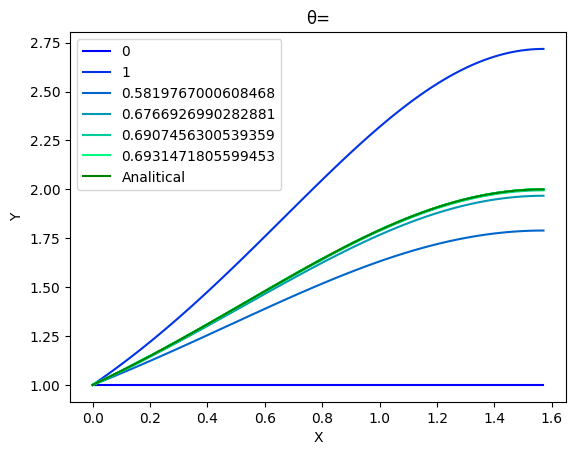

In [83]:

STrajectory = np.zeros((len(ThetaList), StepsNumber+1, 3))

ColoresCount = 5

fig, ax  = plt.subplots()
ax.set(xlabel='X', ylabel='Y', title='θ=')

CMap = get_cmap('winter')
Colors = [CMap(i / ColoresCount) for i in range(ColoresCount+1)]  

LinesLegend = []

for index, Theta in enumerate(ThetaList):

    dY_start = Theta

    state = np.array((X_start, Y_start, dY_start))

    STrajectory[index,0] = state

    for step in range(StepsNumber):
        STrajectory[index, step+1] = RK4_step(STrajectory[index, step])

    color = Colors[index] if index < ColoresCount else Colors[ColoresCount]

    line, = ax.plot(STrajectory[index, :, 0], STrajectory[index, :, 1], color=color, label=str(Theta))

    if(index < ColoresCount):
        LinesLegend.append(line)


SATrajectory = np.zeros((StepsNumber+1, 3))
dY_start = Theta_analitical
state = np.array((X_start, Y_start, dY_start))

SATrajectory[0] = state

for step in range(StepsNumber):
    SATrajectory[step+1] = RK4_step(SATrajectory[step])

line_theta_analitical, = ax.plot(SATrajectory[:, 0], SATrajectory[:, 1], color=Colors[ColoresCount], label=Theta_analitical)

line_analitical, = ax.plot(STrajectory[index, :, 0], Y_analitical(STrajectory[index, :, 0]), color='green', label='Analitical')

ax.legend(handles=LinesLegend + [line_theta_analitical, line_analitical])

plt.show()